<a href="https://colab.research.google.com/github/isBre/Automated-Basketball-Highlights-with-Deep-Learning/blob/main/SketchZoo_Animal_Image_Retrieval_with_Siamese_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [18]:
from torchvision import transforms
from torchvision import models
from torchvision.datasets import ImageFolder

import random

import numpy as np

import torch
from torch import optim, Tensor
from torch.optim import Adam
from torch.nn import Module, Sequential, Linear, ReLU, Conv2d, MaxPool2d, AdaptiveMaxPool2d, Dropout
from torch.nn.modules import loss
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from torch import device

from timeit import default_timer as timer

from typing import Dict, Callable, Tuple

import matplotlib.pyplot as plt

from PIL import Image as IMG

from IPython.display import HTML, Image
from google.colab.output import eval_js
from base64 import b64decode

# Classes and Functions

In [19]:
class ContrastiveDataset(Dataset):

    def __init__(self, images_ds : Dataset, sketches_ds : Subset, transform : transforms = None):
        self.images_ds = images_ds
        self.sketches_ds = sketches_ds
        self.transform = transform
        self.sketches_dict = self.create_sketches_dict()


    def create_sketches_dict(self):
        class_indices = {}
        for idx, (_, label) in enumerate(self.sketches_ds):
            if label not in class_indices:
                class_indices[label] = []
            class_indices[label].append(idx)
        return class_indices
        

    def __getitem__(self, index):
        image, image_class = self.images_ds[index]

        #We need to approximately 50% of images to be in the same class
        should_get_same_class = random.randint(0, 1)

        if should_get_same_class:
            idx = random.choice(self.sketches_dict[image_class])
        
        else:
            random_class = random.choice([idx for idx in list(self.sketches_dict.keys()) if idx != image_class])
            idx = random.choice(self.sketches_dict[random_class])
        
        if self.transform:
            image = self.transform(image)
        sketch, sketch_class = self.sketches_ds[idx]
        inputs = torch.stack((image, sketch))

        # Indicate whether a pair of samples (input1 and input2) are similar or dissimilar
        # 0: are the same class, 1: different class
        target = torch.tensor([(image_class != sketch_class)]).long()
        
        return inputs, target
    

    def __len__(self):
        return len(self.images_ds)


class AugmentedContrastiveDataset(ContrastiveDataset):
  def __init__(self, images_ds : Dataset, sketches_ds : Subset, transform : transforms = None):
    super().__init__(images_ds, sketches_ds, transform)

  def __getitem__(self, idx):
    input, target = super().__getitem__(idx)
    return torch.stack((self.transform(input[0]), self.transform(input[1]))), target


class TripletDataset(Dataset):

    def __init__(self, images_ds : Dataset, sketches_ds : Subset, transform : transforms = None):
        self.images_ds = images_ds
        self.sketches_ds = sketches_ds
        self.transform = transform
        self.sketches_dict = self.create_sketches_dict()
    

    def create_sketches_dict(self):
        class_indices = {}
        for idx, (_, label) in enumerate(self.sketches_ds):
            if label not in class_indices:
                class_indices[label] = []
            class_indices[label].append(idx)
        return class_indices


    def __getitem__(self, index):
        image, image_class = self.images_ds[index]

        positive_idx = random.choice(self.sketches_dict[image_class])
        random_negative_class = random.choice([idx for idx in list(self.sketches_dict.keys()) if idx != image_class])
        negative_idx = random.choice(self.sketches_dict[random_negative_class])
          
        positive_sketch, _, = self.sketches_ds[positive_idx]
        negative_sketch, _ = self.sketches_ds[negative_idx]

        inputs = torch.stack((image, positive_sketch, negative_sketch))
        # Indicate whether a pair of samples (input1 and input2) are similar or dissimilar
        # 0: are the same class, 1: different class
        target = torch.tensor([0, 1])
        
        return inputs, target
    

    def __len__(self):
        return len(self.images_ds)
    

class AugmentedTripletDataset(TripletDataset):
  def __init__(self, images_ds : Dataset, sketches_ds : Subset, transform : transforms = None):
    super().__init__(images_ds, sketches_ds, transform)

  def __getitem__(self, idx):
    input, target = super().__getitem__(idx)
    return torch.stack((self.transform(input[0]), self.transform(input[1]), self.transform(input[2]))), target

In [20]:
class EarlyStopper:
  """
  Represent an object that is able to tell when the train need to stop.
  Needs to be put inside the train and keep updated, when early_stop returns
  true we need to stop the train
  """
  def __init__(self, patience : int = 1, min_delta : int = 0):
      self.patience = patience
      self.min_delta = min_delta
      self.counter = 0
      self.min_validation_loss = np.inf

  def early_stop(self, validation_loss : float) -> bool:
      if validation_loss < self.min_validation_loss:
          self.min_validation_loss = validation_loss
          self.counter = 0
      elif validation_loss > (self.min_validation_loss + self.min_delta):
          self.counter += 1
          if self.counter >= self.patience:
              return True
      return False

In [21]:
class EmbeddingSpace():

  '''
  Every image should be represented as an embedding vector,
  Here we have a representation of an embedding space
  '''

  def __init__(self,  model: Module,
                      loader_images : DataLoader,
                      device: torch.device):
    
    """Create the embedding space

    Args:
        model: the CNN backbone.
        loader_images: dataloader of images.
    """
    self.device = device
    self.model = model.eval().to(self.device)
    self.embeddings = torch.tensor([]).to(self.device)
    self.classes = torch.tensor([]).to(self.device)

    for idx_batch, (images, images_class) in enumerate(loader_images):

      images, images_class = images.to(self.device), images_class.to(self.device)
      with torch.no_grad():
        out = torch.squeeze(model.forward_once(images)).to(self.device)
        self.embeddings = torch.cat((self.embeddings, out))
        self.classes = torch.cat((self.classes, images_class))





  def top_k(self, sketches: torch.Tensor, k: int):
    
    with torch.no_grad():
      sketch_embeddings = torch.squeeze(self.model.forward_once(sketches.to(self.device)))[None,:]

    distances = torch.cdist(self.embeddings, sketch_embeddings)
    topk_distances, topk_indices = torch.topk(distances, k, largest = False, dim = 0)

    return topk_distances, topk_indices




  def top_k_batch(self, sketches: torch.Tensor, k : int):
    
    with torch.no_grad():
      sketch_embeddings = torch.squeeze(self.model.forward_once(sketches.to(self.device)))

    distances = torch.cdist(self.embeddings, sketch_embeddings)
    topk_distances, topk_indices = torch.topk(distances, k, largest = False, dim = 0)

    return torch.permute(topk_distances, (1,0)), torch.permute(topk_indices, (1,0))
  


In [22]:
class ContrastiveLoss(Module):

    def __init__(self, margin : int):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, outputs : torch.Tensor, label : torch.Tensor):

        if outputs.size()[0] == 2:
      
            euclidean_distance = F.pairwise_distance(outputs[0], outputs[1], keepdim = True)
            loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                            (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min = 0.0), 2))
                
            return loss_contrastive
      
        raise ValueError('This is the Contrastive Loss but more (or less) than 2 tensors were unpacked')





class TripletLoss(Module):
    def __init__(self, margin : int):
        super(TripletLoss, self).__init__()
        self.margin = margin
    
    def forward(self, outputs : torch.Tensor, labels : torch.Tensor) -> torch.Tensor:
        
        if len(outputs) == 3:

            positive_distance = F.pairwise_distance(outputs[0], outputs[1])
            negative_distance = F.pairwise_distance(outputs[0], outputs[2])
            losses = torch.relu(positive_distance - negative_distance + self.margin)

            return torch.mean(losses)
        
        raise ValueError('This is the Triplet Loss but more (or less) than 3 tensors were unpacked')

In [23]:
def k_precision(model: Module,
                  sketches_val_loader: DataLoader,
                  embedding_space: EmbeddingSpace,
                  k: int,
                  device: device) -> Tuple[float, float]:
    
    # Corrected Labeled samples
    correct = 0.0
    samples_val = 0

    # IMPORTANT: from now on, since we will introduce batch norm, 
    # we have to tell PyTorch if we are training or evaluating our model
    model = model.eval()

    # Context-manager that disabled gradient calculation
    with torch.no_grad():

      # Loop inside the data_loader
      # The batch size is definited inside the data_loader
      for idx_batch, (sketches, labels) in enumerate(sketches_val_loader):
        
        sketches, labels = sketches.to(device), labels.to(device)

        distances, topk_indexes = embedding_space.top_k_batch(sketches, k)

        correct += torch.sum(torch.tensor([embedding_space.classes[idx] == labels[i] 
                                           for list_idx, i in zip(topk_indexes, list(range(len(topk_indexes)))) 
                                           for idx in list_idx]).float()) / k
        samples_val += len(sketches)
    
    accuracy = 100. * correct / samples_val

    return accuracy

In [24]:
'''
The input received here is
(BATCH_SIZE, INPUTS_LEN, CHANNELS = 3, HEIGHT = 256, WIDTH = 256)
'''

class SiameseNetwork(Module):

    def __init__(self, output : int, backbone: models):
        super(SiameseNetwork, self).__init__()

        self.backbone = backbone
        
        self.backbone.fc = Sequential (
            Linear(self.backbone.fc.in_features, 256),
            ReLU(inplace = True),
            Linear(256, 128),
            ReLU(inplace = True),
            Linear(128, output)
        )


    def forward_once(self, x : torch.Tensor):
        return self.backbone(x)


    def forward(self, inputs : torch.Tensor):

        if len(inputs) == 2:
            return torch.stack((self.forward_once(inputs[0]),
                                self.forward_once(inputs[1])))
        
        if len(inputs) == 3:
            return torch.stack((self.forward_once(inputs[0]),
                                self.forward_once(inputs[1]),
                                self.forward_once(inputs[2]),))

        raise ValueError(f'This is the SiameseBaseline, the number of input tensor is not 2 or 3 {inputs.size()}')

In [25]:
def training_loop(num_epochs: int, 
                  optimizer: optim,
                  model: Module, 
                  si_train_loader: DataLoader, 
                  si_val_loader: DataLoader,
                  sketches_test_loader: DataLoader,
                  images_dataloader: DataLoader,
                  loss_func: loss,
                  k: int,
                  device: device,
                  accuracy_margin: float,
                  verbose: bool = True,
                  early_stopping: EarlyStopper = None) -> Dict:

    # Start the timer in order to obtain the time needed to entirely train the model
    loop_start = timer()

    train_losses_values = []
    val_losses_values = []
    train_acc_values = []
    val_acc_values = []
    k_prec_values = []

    # For every epoch
    for epoch in range(1, num_epochs + 1):

      # Start the timer in order to obtain the time needed to train in this epoch
      time_start = timer()

      # Obtain Loss and Accuracy for the train step
      loss_train, accuracy_train = train(optimizer, model, si_train_loader, 
                                         loss_func, accuracy_margin, device)

      # Obtain Loss and Accuracy for the validate step
      loss_val, accuracy_val = validate(model, si_val_loader, loss_func, accuracy_margin, device)
      
      # Calculate the k-accuracy
      embedding_space = EmbeddingSpace(model, images_dataloader, device)
      k_prec = k_precision(model, sketches_test_loader, embedding_space, k, device)   

      #Stop the timer for this step
      time_end = timer()

      # Update history
      train_losses_values.append(loss_train)
      train_acc_values.append(accuracy_train)
      val_losses_values.append(loss_val)
      val_acc_values.append(accuracy_val)
      k_prec_values.append(k_prec)
      
      # Metrics Print
      lr =  optimizer.param_groups[0]['lr']
      if verbose:            
          print(f'Epoch: {epoch} '
                f' Lr: {lr:.8f} '
                f' Loss: Train = [{loss_train:.4f}] - Val [{loss_val:.4f}]'
                f' Accuracy: Train = [{accuracy_train:.2f}%] - Val = [{accuracy_val:.2f}%] '
                f' P@{k}: [{k_prec:.2f}%]'
                f' Time one epoch (s): {(time_end - time_start):.2f} ')
    
      if early_stopping is not None:
        if early_stopping.early_stop(loss_val):
          print(f'--- Early Stopping ---')     
          break

    # Stop the timer for the entire training
    loop_end = timer()

    # Calculate total time
    time_loop = loop_end - loop_start

    # Metrics Print
    if verbose:
        print(f'Time for {epoch-1} epochs (s): {(time_loop):.3f}') 
        
    return {'train_loss_values': train_losses_values,
            'train_acc_values': train_acc_values,
            'val_loss_values' : val_losses_values,
            'val_acc_values': val_acc_values,
            'k_acc_values' : k_prec,
            'time': time_loop}





def train(optimizer: optim,
          model: Module,
          dataloader: DataLoader,
          loss_func: Callable[[Tensor, Tensor], float],
          accuracy_margin: float,
          device: device) -> Tuple[float, float]:


    # Initialize Metrics
    correct = 0.0
    samples_train = 0
    loss_train = 0
    num_batches = len(dataloader)

    # IMPORTANT: from now on, since we will introduce batch norm, 
    # we have to tell PyTorch if we are training or evaluating our model
    model.train()

    # Loop inside the train_loader
    # The batch size is definited inside the train_loader
    for inputs, target in dataloader:

      # In order to speed up the process I want to use the current device
      inputs, target = inputs.to(device), target.to(device)

      inputs = torch.permute(inputs, (1, 0, 2, 3, 4))

      # Set the gradient of the available parameters to zero
      optimizer.zero_grad()

      # Get the output of the model
      outputs = model(inputs)
    
      # Here the model calculate the loss comparing true values and obtained values
      loss = loss_func(outputs, target)

      # Update the total loss adding the loss of this particular batch
      loss_train += loss.item() * len(inputs[0])

      # Update the number of analyzed images
      samples_train += len(inputs[0])
      
      # Compute the gradient
      loss.backward()

      # Update parameters considering the loss.backward() values
      optimizer.step()

      # Update the number of correct predicted values adding the correct value of this batch
      correct += get_correct(outputs, target, accuracy_margin, device)


    loss_train /= samples_train
    accuracy_training = 100. * correct / samples_train
    return loss_train, accuracy_training





def validate(model: Module,
             dataloader: DataLoader,
             loss_func: Callable[[Tensor, Tensor], float],
             accuracy_margin: float,
             device: torch.device) -> Tuple[float, float]:

  # Corrected Labeled samples
  correct = 0

  # Images in the batch
  samples_val = 0

  # Loss of the Valuation Set
  loss_val = 0.

  # IMPORTANT: from now on, since we will introduce batch norm, we have to tell PyTorch if we are training or evaluating our model
  model = model.eval()

  # Context-manager that disabled gradient calculation
  with torch.no_grad():

    # Loop inside the data_loader
    # The batch size is definited inside the data_loader
    for inputs, target in dataloader:

      # In order to speed up the process I want to use the current device
      inputs, target = inputs.to(device), target.to(device)
      inputs = torch.permute(inputs, (1, 0, 2, 3, 4))

      # Get the output of the model
      # I need to squeeze because of the dimension of the output (x, 1), I want just (x)
      outputs = model(inputs)

      # Here the model calculate the loss comparing true values and obtained values
      # Here i need to cast to float32 because: labels is long and outputs is float32
      loss = loss_func(outputs, target)

      # Update metrics
      loss_val += loss.item() * len(inputs[0])
      samples_val += len(inputs[0])
      correct += get_correct(outputs, target, accuracy_margin, device)

  loss_val /= samples_val
  accuracy = 100. * correct / samples_val
  return loss_val, accuracy





def get_correct(outputs: torch.Tensor,
                labels: torch.Tensor,
                accuracy_margin: float,
                device = device) -> float:

    if len(outputs) == 2:

      distances = F.pairwise_distance(outputs[0], outputs[1]).to(device)
      results = torch.tensor([0 if d < accuracy_margin else 1 for d in distances]).to(device)
      matches = torch.eq(results, torch.squeeze(labels)).float().to(device)

      return torch.sum(matches)


    if len(outputs) == 3:

      positive_distances = F.pairwise_distance(outputs[0], outputs[1]).to(device)
      negative_distances = F.pairwise_distance(outputs[0], outputs[2]).to(device)
      results = torch.tensor([1 if p < n else 0 for p, n in zip(positive_distances, negative_distances)]).to(device)

      return torch.sum(results)
    
    raise ValueError(f'Output with wrong dimension in get_correct{outputs.size()}')

In [26]:
def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use. 
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

# Download Datasets

In [67]:
#Download Full Dataset
!gdown 119fp_2s6ZWsF2MqucD3w8ForuSGKomMn
!unzip /content/Dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: 256x256/sketch/songbird/n01594787_11525-5.png  
  inflating: 256x256/sketch/songbird/n01594787_11525-6.png  
  inflating: 256x256/sketch/songbird/n01594787_13577-1.png  
  inflating: 256x256/sketch/songbird/n01594787_13577-2.png  
  inflating: 256x256/sketch/songbird/n01594787_13577-3.png  
  inflating: 256x256/sketch/songbird/n01594787_13577-4.png  
  inflating: 256x256/sketch/songbird/n01594787_13577-5.png  
  inflating: 256x256/sketch/songbird/n01594787_13738-1.png  
  inflating: 256x256/sketch/songbird/n01594787_13738-2.png  
  inflating: 256x256/sketch/songbird/n01594787_13738-3.png  
  inflating: 256x256/sketch/songbird/n01594787_13738-4.png  
  inflating: 256x256/sketch/songbird/n01594787_13738-5.png  
  inflating: 256x256/sketch/songbird/n01594787_13738-6.png  
  inflating: 256x256/sketch/songbird/n01594787_14138-1.png  
  inflating: 256x256/sketch/songbird/n01594787_14138-2.png  
  inflating: 256x256/sketch/songbi

In [68]:
#Download Mini Dataset
!gdown 1g64jNCAWVhHO8tQMsK1eQcl8E5b25tjm
!unzip /content/Mini\ Dataset.zip

Downloading...
From: https://drive.google.com/uc?id=1g64jNCAWVhHO8tQMsK1eQcl8E5b25tjm
To: /content/Mini Dataset.zip
100% 44.2M/44.2M [00:00<00:00, 130MB/s]
Archive:  /content/Mini Dataset.zip
replace Mini Dataset/photo/bear/n02131653_10374.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Mini Dataset/photo/bear/n02131653_10683.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# 🔹Experiments with Mini-Dataset

To ensure the initial functionality of the system, I opted to work with a **small subset of the complete dataset**. The subset consists of 5 Classes (bear, crocodilian, jellyfish, parrot, spider) and comprises a total of 500 Images and 3076 Sketches.

## Configurations Variables

In [77]:
#Pick a Dataset (you can use the dictionary up here as reference)
#   Note that the dataset should be partitioned in folder readable by the ImageFolder class
#   You can download the dataset here: https://sketchy.eye.gatech.edu/
DATASET_NAME = 'mini-dataset'
PHOTO_DATASET_PATH, SKETCHES_DATASET_PATH = "/content/Mini Dataset/photo", "/content/Mini Dataset/sketch"

#Pick a Dataset Type 
#   For training: ContrastiveDataset, TripletDataset, AugmentedContrastiveDataset, AugmentedTripletDataset
#   For validation: ContrastiveDataset, TripletDataset
#   IMPORTANT: If you are using an Augmented dataset remember to assing Composed Trasformations to TRANSFORMATION
TRAIN_DATASET_TYPE = ContrastiveDataset
TRANSFORMATION = None
VAL_DATASET_TYPE = ContrastiveDataset

#Pick a Criterion
#   This criterion MUST coincide with the previous dataset type
#   You can chose between: ContrastiveLoss, TripletLoss
CRITERION = ContrastiveLoss

#Pick an embedding size
#   Within the embedding space, we have numerous vectors, each with this dimension
#   If a higher level of detail is required, increase this value
#   In case of memory constraints, decrease it
OUTPUT_EMBEDDING = 2

#Choose a Weight Path
#   After the training your weight are going to be saved here
WEIGHT_PATH = f"/content/{DATASET_NAME}-{OUTPUT_EMBEDDING}-contrastive-.pth"

#Pick a Margin
#   This is the input value provided to the contrastive loss and triplet loss
#   represents the proximity required between values to be associated with the same class
#   2.0 seems to be working reasonably well
MARGIN = 2.0

#Pick an Accuracy Margin
#   This value is used for training purposes
#   represents the proximity required between values to be associated with the same class
ACCURACY_MARGIN = 0.5

#Pick a K (for the K-Precision)
#   It is used to represent the k factor for calculating k-accuracy within the training process.
K = 12

#Pick a Batch Size
BATCH_SIZE = 16

#Pick a Backbone
#   The backbone represents the neural network within the siamese network, 
#   after which several linear layers will be applied to produce an embedding of size EMBEDDING_SIZE.
backbone = models.resnet18(weights = models.ResNet18_Weights.IMAGENET1K_V1)


DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"You're using: {DEVICE}")
torch.set_default_dtype(torch.float32)
fix_random(42)
generator1 = torch.Generator().manual_seed(42)
workers = 0

You're using: cuda:0


## Datasets Creation

In [78]:
#Images and Sketch
images_ds = ImageFolder(PHOTO_DATASET_PATH, transform = transforms.ToTensor())
images_loader = DataLoader(images_ds, shuffle = False, num_workers = workers, pin_memory = True, batch_size = BATCH_SIZE)
images_train_ds, images_val_ds = random_split(images_ds, (0.8, 0.2), generator = generator1)
images_train_dl = DataLoader(images_train_ds, shuffle = False, num_workers = workers, pin_memory = True, batch_size = BATCH_SIZE)
images_val_dl = DataLoader(images_val_ds, shuffle = False, num_workers = workers, pin_memory = True, batch_size = BATCH_SIZE)

sketches_ds = ImageFolder(SKETCHES_DATASET_PATH, transform = transforms.ToTensor())
sketches_loader = DataLoader(sketches_ds, shuffle = False, num_workers = workers, pin_memory = True, batch_size = BATCH_SIZE)
sketches_train_ds, sketches_val_ds, sketches_k_acc = random_split(sketches_ds, (0.8, 0.15, 0.05), generator = generator1)
small_sketches_loader = DataLoader(sketches_k_acc, shuffle = False, num_workers = workers, pin_memory = True, batch_size = BATCH_SIZE)

si_train_dataset = TRAIN_DATASET_TYPE(images_train_ds, sketches_train_ds, TRANSFORMATION)
si_train_loader = DataLoader(si_train_dataset, shuffle = True, num_workers = workers, pin_memory = True, batch_size = BATCH_SIZE)
si_val_dataset = VAL_DATASET_TYPE(images_val_ds, sketches_val_ds)
si_val_loader = DataLoader(si_val_dataset, shuffle = False, num_workers = workers, pin_memory = True, batch_size = BATCH_SIZE)

## 📊 Dataset Plots

### Distribution

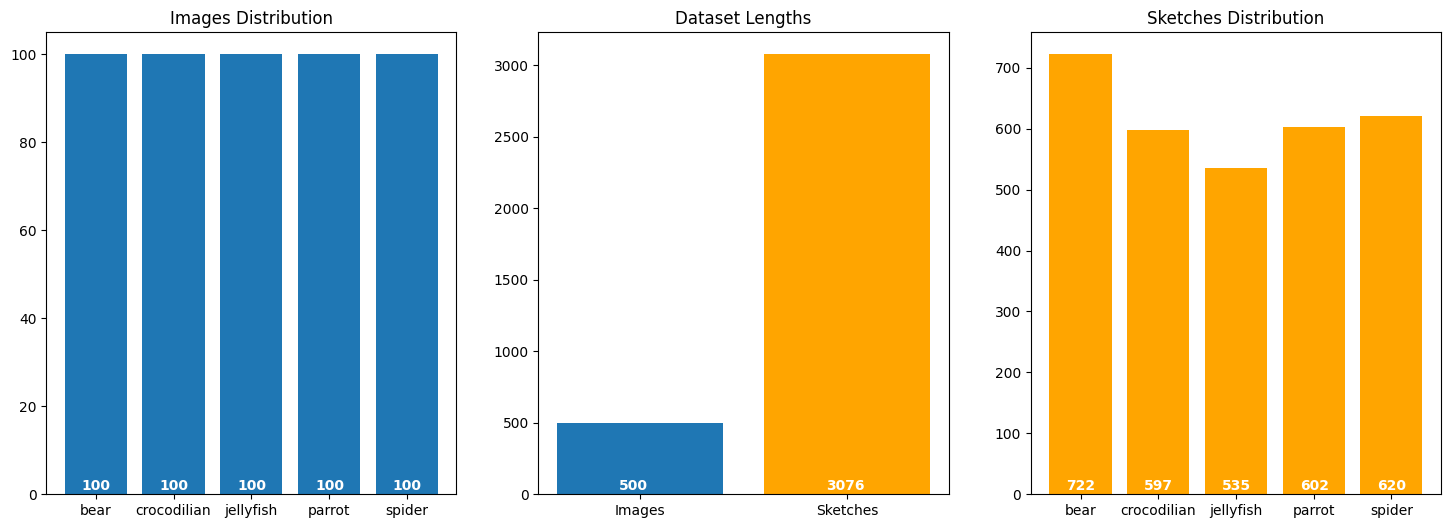

In [102]:
images_labels = [sample[1] for sample in images_ds]
sketches_labels = [sample[1] for sample in sketches_ds]

# Count the occurrences of each class
class_counts_images = torch.bincount(torch.tensor(images_labels))
class_counts_sketches = torch.bincount(torch.tensor(sketches_labels))

# Plotting the bar graph
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plotting the bar graph for dataset1
axs[0].bar(images_ds.classes, class_counts_images, color = "tab:blue")
axs[0].set_title('Images Distribution')
axs[0].set_xticks(range(len(class_counts_images)))

for i in range(len(class_counts_images)):
    axs[0].text(i - 0.18, 1, str(f'{class_counts_images[i]}'), 
             color = "white", fontweight = 'bold')


axs[1].bar(['Images', 'Sketches'], [len(images_ds), len(sketches_ds)], color = ['tab:blue', 'orange'])
axs[1].set_title('Dataset Lengths')
axs[1].set_xticks(['Images', 'Sketches'])

for i in range(2):
    axs[1].text(i - 0.10, 30, str(f"{[len(images_ds), len(sketches_ds)][i]}"), 
             color = "white", fontweight = 'bold')


axs[2].bar(sketches_ds.classes, class_counts_sketches, color = 'orange')
axs[2].set_title('Sketches Distribution')
axs[2].set_xticks(range(len(class_counts_sketches)))

for i in range(len(class_counts_sketches)):
    axs[2].text(i - 0.18, 7, str(f'{class_counts_sketches[i]}'), 
             color = "white", fontweight = 'bold')


plt.show()


### Example Data

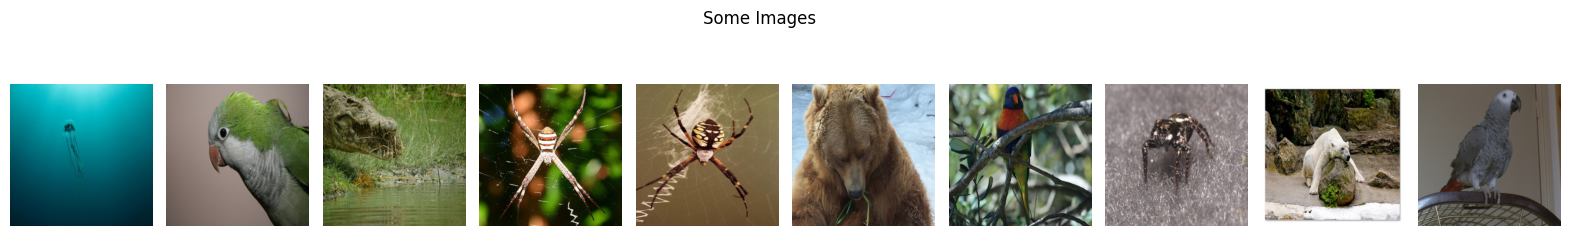

In [108]:
NUM_IMAGES = 10

# Create a list of random indices
indices = random.sample(range(len(images_ds)), NUM_IMAGES)

# Define the image transformation
transform = transforms.ToPILImage()

# Plot the randomly selected images
fig, axes = plt.subplots(1, NUM_IMAGES, figsize=(20, 3))

for i, index in enumerate(indices):
    image, _ = images_ds[index]
    image = transform(image)
    axes[i].imshow(image)
    axes[i].axis('off')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.1)
plt.suptitle('Some Images')

# Display the images
plt.show()


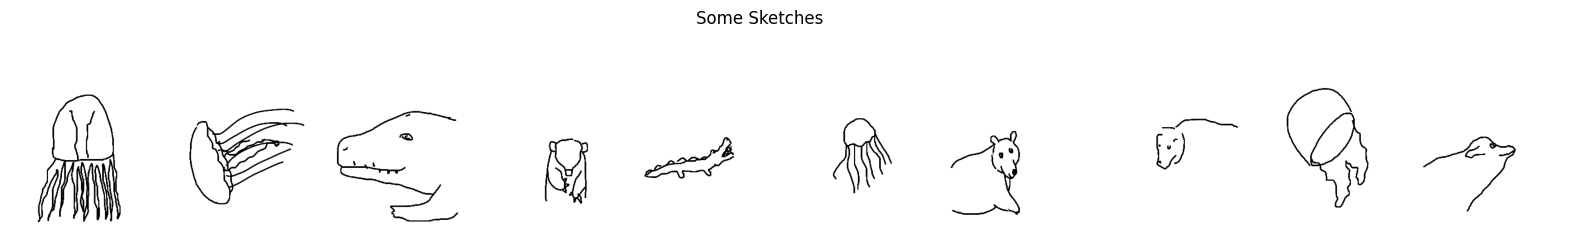

In [109]:
NUM_SKETCHES = 10

# Create a list of random indices
indices = random.sample(range(len(sketches_ds)), NUM_SKETCHES)

# Define the image transformation
transform = transforms.ToPILImage()

# Plot the randomly selected images
fig, axes = plt.subplots(1, NUM_SKETCHES, figsize=(20, 3))

for i, index in enumerate(indices):
    image, _ = sketches_ds[index]
    image = transform(image)
    axes[i].imshow(image)
    axes[i].axis('off')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.1)
plt.suptitle('Some Sketches')

# Display the images
plt.show()


## Train [You can skip this part here]

In [29]:
#Pick a Learning Rate
lr = 1e-4

#Pick a number of Epochs
num_epochs = 500

criterion = CRITERION(MARGIN)
net = SiameseNetwork(output = OUTPUT_EMBEDDING, backbone = backbone).to(DEVICE)

optimizer = Adam(net.parameters(), lr = lr)
early_stopper = EarlyStopper(patience = 5, min_delta = 0)

history = training_loop(num_epochs, optimizer, net, 
                        si_train_loader, si_val_loader, small_sketches_loader, 
                        images_loader, criterion, K, DEVICE, ACCURACY_MARGIN,
                        early_stopping = early_stopper)

torch.save(net.state_dict(), WEIGHT_PATH)

Epoch: 1  Lr: 0.00010000  Loss: Train = [1.4041] - Val [1.1697] Accuracy: Train = [51.25%] - Val = [49.00%]  P@12: [24.35%] Time one epoch (s): 7.41 
Epoch: 2  Lr: 0.00010000  Loss: Train = [0.8256] - Val [0.9927] Accuracy: Train = [59.75%] - Val = [52.00%]  P@12: [25.00%] Time one epoch (s): 7.98 
Epoch: 3  Lr: 0.00010000  Loss: Train = [0.7107] - Val [1.0489] Accuracy: Train = [63.00%] - Val = [47.00%]  P@12: [33.50%] Time one epoch (s): 9.76 
Epoch: 4  Lr: 0.00010000  Loss: Train = [0.5781] - Val [0.8760] Accuracy: Train = [69.25%] - Val = [50.00%]  P@12: [43.36%] Time one epoch (s): 7.64 
Epoch: 5  Lr: 0.00010000  Loss: Train = [0.4941] - Val [0.7914] Accuracy: Train = [74.75%] - Val = [62.00%]  P@12: [41.88%] Time one epoch (s): 7.59 
Epoch: 6  Lr: 0.00010000  Loss: Train = [0.4429] - Val [1.0256] Accuracy: Train = [74.75%] - Val = [49.00%]  P@12: [38.56%] Time one epoch (s): 9.10 
Epoch: 7  Lr: 0.00010000  Loss: Train = [0.4112] - Val [0.7311] Accuracy: Train = [75.75%] - Val = [

## Load or Save Weights

In [31]:
#Download the two predefinited weights 
!gdown 1qe3-dV-PWpxcAT8LBkf3E9nI--fgkOtq
!gdown 11NkDEc9xz6WyNFkv0M5WAlM6hazgG9vC


CONTRASTIVE_WEIGHT_PATH = '/content/mini-2-contrastive.pth'
TRIPLET_WEIGHT_PATH = '/content/mini-2-triplet.pth'

backbone = models.resnet18()
contrastive_net = SiameseNetwork(output = OUTPUT_EMBEDDING, backbone = backbone).to(DEVICE)
contrastive_net.load_state_dict(torch.load(CONTRASTIVE_WEIGHT_PATH))

backbone = models.resnet18()
triplet_net = SiameseNetwork(output = OUTPUT_EMBEDDING, backbone = backbone).to(DEVICE)
triplet_net.load_state_dict(torch.load(TRIPLET_WEIGHT_PATH))

Downloading...
From: https://drive.google.com/uc?id=1qe3-dV-PWpxcAT8LBkf3E9nI--fgkOtq
To: /content/mini-2-contrastive.pth
100% 45.4M/45.4M [00:00<00:00, 149MB/s]
Downloading...
From: https://drive.google.com/uc?id=11NkDEc9xz6WyNFkv0M5WAlM6hazgG9vC
To: /content/mini-2-triplet.pth
100% 45.4M/45.4M [00:00<00:00, 73.9MB/s]


<All keys matched successfully>

## 📊 Plots

In [ ]:
full_contrastive_ES = EmbeddingSpace(contrastive_net, images_train_dl, DEVICE)
full_triplet_ES = EmbeddingSpace(triplet_net, images_train_dl, DEVICE)
val_contrastive_ES = EmbeddingSpace(contrastive_net, images_val_dl, DEVICE)
val_triplet_ES = EmbeddingSpace(triplet_net, images_val_dl, DEVICE)

### Embeddings Space

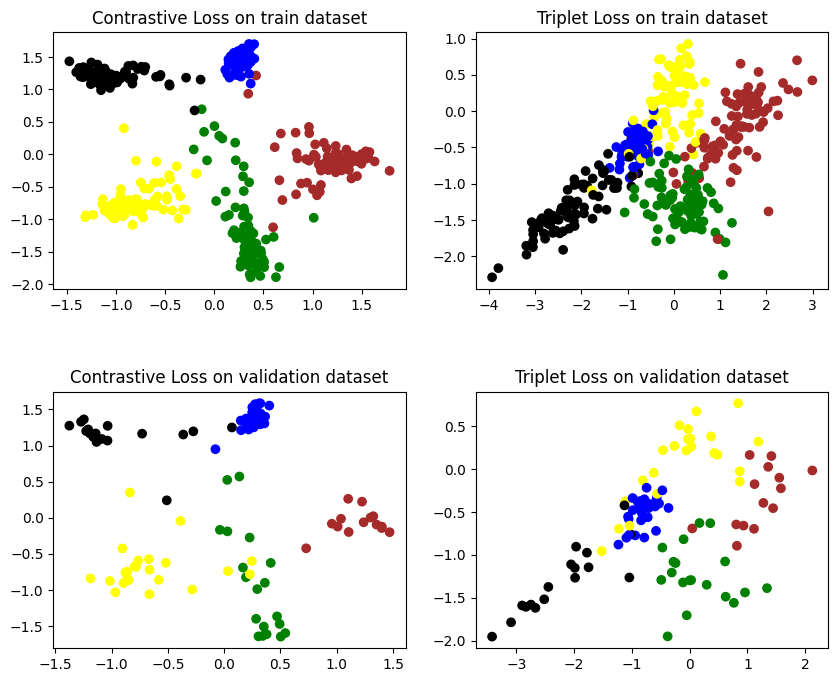

In [35]:
colours_dict = {0 : 'brown', 1 : 'green', 2 : 'blue', 3: 'yellow', 4 :'black'}
colors_full_contrastive_ES = [colours_dict[c.item()] for c in full_contrastive_ES.classes]
colors_full_triplet_ES = [colours_dict[c.item()] for c in full_triplet_ES.classes]
colors_val_contrastive_ES = [colours_dict[c.item()] for c in val_contrastive_ES.classes]
colors_val_triplet_ES = [colours_dict[c.item()] for c in val_triplet_ES.classes]

# Create a figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Scatter plot 1
axes[0, 0].scatter(torch.permute(full_contrastive_ES.embeddings, (1,0)).tolist()[0],
                   torch.permute(full_contrastive_ES.embeddings, (1,0)).tolist()[1],
                   color = colors_full_contrastive_ES)
axes[0, 0].set_title('Contrastive Loss on train dataset')

# Scatter plot 2
axes[0, 1].scatter(torch.permute(full_triplet_ES.embeddings, (1,0)).tolist()[0],
                   torch.permute(full_triplet_ES.embeddings, (1,0)).tolist()[1],
                   color = colors_full_triplet_ES)
axes[0, 1].set_title('Triplet Loss on train dataset')

# Scatter plot 3
axes[1, 0].scatter(torch.permute(val_contrastive_ES.embeddings, (1,0)).tolist()[0],
                   torch.permute(val_contrastive_ES.embeddings, (1,0)).tolist()[1],
                   color = colors_val_contrastive_ES)
axes[1, 0].set_title('Contrastive Loss on validation dataset')

# Scatter plot 4
axes[1, 1].scatter(torch.permute(val_triplet_ES.embeddings, (1,0)).tolist()[0],
                   torch.permute(val_triplet_ES.embeddings, (1,0)).tolist()[1],
                   color = colors_val_triplet_ES)
axes[1, 1].set_title('Triplet Loss on validation dataset')

# Adjust vertical space between subplots
plt.subplots_adjust(hspace=0.4)

# Display the figure
plt.show()

### P@K Contrastive vs Triplet

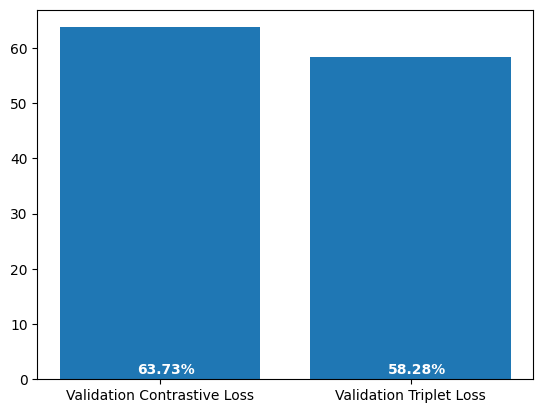

In [55]:
#Create the dictionary for the final graph
#   For each experiment pick the backbone, the embedding_size and the weight_path
dict={0: {'backbone' : models.resnet18(), 'embedding_size' : 2, 'weight_path' : CONTRASTIVE_WEIGHT_PATH},
      1: {'backbone' : models.resnet18(), 'embedding_size' : 2, 'weight_path' : TRIPLET_WEIGHT_PATH}}


results = []

for k in list(dict.keys()):
    net = SiameseNetwork(output = dict[k]['embedding_size'], backbone = dict[k]['backbone']).to(DEVICE)
    net.load_state_dict(torch.load(dict[k]['weight_path']))
    net = net.eval()
    with torch.no_grad():
        embedding_space1 = EmbeddingSpace(net, images_val_dl, DEVICE)
        results.append(k_precision(net, small_sketches_loader, embedding_space1, K, DEVICE))

for i in range(len(results)):
    plt.text(i - 0.09, 1, str(f'{results[i].item():.2f}%'), 
             color = "white", fontweight = 'bold')


plt.bar(["Validation Contrastive Loss", "Validation Triplet Loss"], results)
plt.show()

# 🔹Experiments with Full-Dataset

## Configurations Variables

In [110]:
#Pick a Dataset (you can use the dictionary up here as reference)
#   Note that the dataset should be partitioned in folder readable by the ImageFolder class
#   You can download the dataset here: https://sketchy.eye.gatech.edu/
DATASET_NAME = 'animal-domain'
PHOTO_DATASET_PATH, SKETCHES_DATASET_PATH = "/content/256x256/photo", "/content/256x256/sketch"

#Pick a Dataset Type 
#   For training: ContrastiveDataset, TripletDataset, AugmentedContrastiveDataset, AugmentedTripletDataset
#   For validation: ContrastiveDataset, TripletDataset
#   IMPORTANT: If you are using an Augmented dataset remember to assing Composed Trasformations to TRANSFORMATION
TRAIN_DATASET_TYPE = ContrastiveDataset
TRANSFORMATION = None
VAL_DATASET_TYPE = ContrastiveDataset

#Pick a Criterion
#   This criterion MUST coincide with the previous dataset type
#   You can chose between: ContrastiveLoss, TripletLoss
CRITERION = ContrastiveLoss

#Pick an embedding size
#   Within the embedding space, we have numerous vectors, each with this dimension
#   If a higher level of detail is required, increase this value
#   In case of memory constraints, decrease it
OUTPUT_EMBEDDING = 16

#Choose a Weight Path
#   After the training your weight are going to be saved here
WEIGHT_PATH = f"/content/weights/{DATASET_NAME}-{OUTPUT_EMBEDDING}-contrastive-resnet50.pth"

#Pick a Margin
#   This is the input value provided to the contrastive loss and triplet loss
#   represents the proximity required between values to be associated with the same class
#   2.0 seems to be working reasonably well
MARGIN = 2.0

#Pick an Accuracy Margin
#   This value is used for training purposes
#   represents the proximity required between values to be associated with the same class
ACCURACY_MARGIN = 0.5

#Pick a K (for the K-Precision)
#   It is used to represent the k factor for calculating k-accuracy within the training process.
K = 12

#Pick a Batch Size
BATCH_SIZE = 16

#Pick a Backbone
#   The backbone represents the neural network within the siamese network, 
#   after which several linear layers will be applied to produce an embedding of size EMBEDDING_SIZE.
backbone = models.resnet50(weights = models.ResNet50_Weights.IMAGENET1K_V2)


DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"You're using: {DEVICE}")
torch.set_default_dtype(torch.float32)
fix_random(42)
generator1 = torch.Generator().manual_seed(42)
workers = 0

You're using: cuda:0


## Datasets Creation

In [111]:
#Images and Sketch
images_ds = ImageFolder(PHOTO_DATASET_PATH, transform = transforms.ToTensor())
images_loader = DataLoader(images_ds, shuffle = False, num_workers = workers, pin_memory = True, batch_size = BATCH_SIZE)
images_train_ds, images_val_ds = random_split(images_ds, (0.8, 0.2), generator = generator1)
images_train_dl = DataLoader(images_train_ds, shuffle = False, num_workers = workers, pin_memory = True, batch_size = BATCH_SIZE)
images_val_dl = DataLoader(images_val_ds, shuffle = False, num_workers = workers, pin_memory = True, batch_size = BATCH_SIZE)

sketches_ds = ImageFolder(SKETCHES_DATASET_PATH, transform = transforms.ToTensor())
sketches_loader = DataLoader(sketches_ds, shuffle = False, num_workers = workers, pin_memory = True, batch_size = BATCH_SIZE)
sketches_train_ds, sketches_val_ds, sketches_k_acc = random_split(sketches_ds, (0.8, 0.15, 0.05), generator = generator1)
small_sketches_loader = DataLoader(sketches_k_acc, shuffle = False, num_workers = workers, pin_memory = True, batch_size = BATCH_SIZE)

si_train_dataset = TRAIN_DATASET_TYPE(images_train_ds, sketches_train_ds, TRANSFORMATION)
si_train_loader = DataLoader(si_train_dataset, shuffle = True, num_workers = workers, pin_memory = True, batch_size = BATCH_SIZE)
si_val_dataset = VAL_DATASET_TYPE(images_val_ds, sketches_val_ds)
si_val_loader = DataLoader(si_val_dataset, shuffle = False, num_workers = workers, pin_memory = True, batch_size = BATCH_SIZE)

## 📊 Dataset Plots

### Distribution

In [ ]:
images_labels = [sample[1] for sample in images_ds]
sketches_labels = [sample[1] for sample in sketches_ds]

# Count the occurrences of each class
class_counts_images = torch.bincount(torch.tensor(images_labels))
class_counts_sketches = torch.bincount(torch.tensor(sketches_labels))

# Plotting the bar graph
fig, axs = plt.subplots(3, 1, figsize=(18, 20))

# Plotting the bar graph for dataset1
axs[0].bar(images_ds.classes, class_counts_images, color = "tab:blue")
axs[0].set_title('Images Distribution')
axs[0].set_xticks(range(len(class_counts_images)))
axs[0].tick_params(axis='x', rotation=90)


axs[1].bar(['Images', 'Sketches'], [len(images_ds), len(sketches_ds)], color = ['tab:blue', 'orange'])
axs[1].set_title('Dataset Lengths')
axs[1].set_xticks(['Images', 'Sketches'])

for i in range(2):
    axs[1].text(i - 0.05, 100, str(f"{[len(images_ds), len(sketches_ds)][i]}"), 
             color = "white", fontweight = 'bold')


axs[2].bar(sketches_ds.classes, class_counts_sketches, color = 'orange')
axs[2].set_title('Sketches Distribution')
axs[2].set_xticks(range(len(class_counts_sketches)))
axs[2].tick_params(axis='x', rotation=90)


plt.subplots_adjust(hspace=0.5)


plt.show()


### Example Data

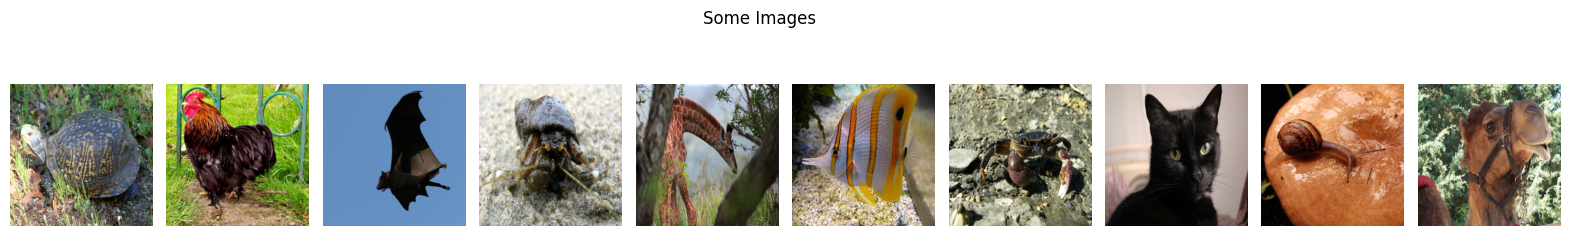

In [116]:
NUM_IMAGES = 10

# Create a list of random indices
indices = random.sample(range(len(images_ds)), NUM_IMAGES)

# Define the image transformation
transform = transforms.ToPILImage()

# Plot the randomly selected images
fig, axes = plt.subplots(1, NUM_IMAGES, figsize=(20, 3))

for i, index in enumerate(indices):
    image, _ = images_ds[index]
    image = transform(image)
    axes[i].imshow(image)
    axes[i].axis('off')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.1)
plt.suptitle('Some Images')

# Display the images
plt.show()


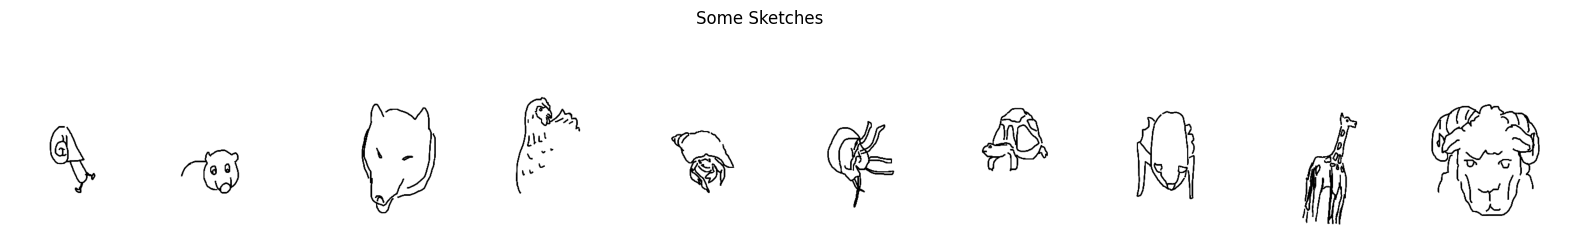

In [117]:
NUM_SKETCHES = 10

# Create a list of random indices
indices = random.sample(range(len(sketches_ds)), NUM_SKETCHES)

# Define the image transformation
transform = transforms.ToPILImage()

# Plot the randomly selected images
fig, axes = plt.subplots(1, NUM_SKETCHES, figsize=(20, 3))

for i, index in enumerate(indices):
    image, _ = sketches_ds[index]
    image = transform(image)
    axes[i].imshow(image)
    axes[i].axis('off')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.1)
plt.suptitle('Some Sketches')

# Display the images
plt.show()


## Train [You can skip this part here]

In [ ]:
#Pick a Learning Rate
lr = 1e-4

#Pick a number of Epochs
num_epochs = 500

criterion = CRITERION(MARGIN)
net = SiameseNetwork(output = OUTPUT_EMBEDDING, backbone = backbone).to(DEVICE)

optimizer = Adam(net.parameters(), lr = lr)
early_stopper = EarlyStopper(patience = 5, min_delta = 0)

history = training_loop(num_epochs, optimizer, net, 
                        si_train_loader, si_val_loader, small_sketches_loader, 
                        images_loader, criterion, K, DEVICE, ACCURACY_MARGIN,
                        early_stopping = early_stopper)

torch.save(net.state_dict(), WEIGHT_PATH)

## Load or Save Weights

In [71]:
#This line download the best model (resnet50 with embedding size equal to 16)
!gdown 1mZT45NVsi9JRiS0wrYDZKIX9SAHAohmm
WEIGHT_PATH = '/content/full-16-contrastive-resnet50.pth'

backbone = models.resnet50()
net = SiameseNetwork(output = OUTPUT_EMBEDDING, backbone = backbone).to(DEVICE)
net.load_state_dict(torch.load(WEIGHT_PATH))

Downloading...
From: https://drive.google.com/uc?id=1mZT45NVsi9JRiS0wrYDZKIX9SAHAohmm
To: /content/full-16-contrastive-resnet50.pth
100% 96.6M/96.6M [00:00<00:00, 197MB/s]


<All keys matched successfully>

## 📊 Plots

In [72]:
#Import Contrastive Weights
!gdown 13g7S3MKJVd8bnF3l70qIkl5jmwCSjVYn
!gdown 1Ku2fBHLmPA-_ZSzoYvQeu7EmnWzjdeu1
!gdown 1mZT45NVsi9JRiS0wrYDZKIX9SAHAohmm
!gdown 1tFTJRd6a8Dpm0drR_SzVcoKmhbZYjYzI

Downloading...
From: https://drive.google.com/uc?id=13g7S3MKJVd8bnF3l70qIkl5jmwCSjVYn
To: /content/full-16-contrastive.pth
100% 45.5M/45.5M [00:00<00:00, 264MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Ku2fBHLmPA-_ZSzoYvQeu7EmnWzjdeu1
To: /content/full-16-contrastive-resnet34.pth
100% 86.0M/86.0M [00:00<00:00, 218MB/s]
Downloading...
From: https://drive.google.com/uc?id=1mZT45NVsi9JRiS0wrYDZKIX9SAHAohmm
To: /content/full-16-contrastive-resnet50.pth
100% 96.6M/96.6M [00:00<00:00, 258MB/s]
Downloading...
From: https://drive.google.com/uc?id=1tFTJRd6a8Dpm0drR_SzVcoKmhbZYjYzI
To: /content/full-16-contrastive-Resnet101.pth
100% 173M/173M [00:01<00:00, 104MB/s] 


### P@K Resnets Comparison

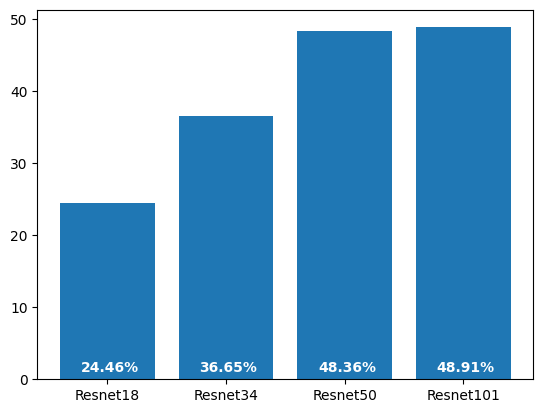

In [73]:
#Create the dictionary for the final graph
#   For each experiment pick the backbone, the embedding_size and the weight_path
dict={0: {'backbone' : models.resnet18(), 'embedding_size' : 16, 'weight_path' : '/content/full-16-contrastive.pth'},
      1: {'backbone' : models.resnet34(), 'embedding_size' : 16, 'weight_path' : '/content/full-16-contrastive-resnet34.pth'},
      2: {'backbone' : models.resnet50(), 'embedding_size' : 16, 'weight_path' : '/content/full-16-contrastive-resnet50.pth'},
      3: {'backbone' : models.resnet101(), 'embedding_size' : 16, 'weight_path' : '/content/full-16-contrastive-Resnet101.pth'}}


results = []

for k in list(dict.keys()):
    net = SiameseNetwork(output = dict[k]['embedding_size'], backbone = dict[k]['backbone']).to(DEVICE)
    net.load_state_dict(torch.load(dict[k]['weight_path']))
    net = net.eval()
    with torch.no_grad():
        embedding_space1 = EmbeddingSpace(net, images_val_dl, DEVICE)
        results.append(k_precision(net, small_sketches_loader, embedding_space1, K, DEVICE))

for i in range(len(results)):
    plt.text(i - 0.225, 1, str(f'{results[i].item():.2f}%'), 
             color = "white", fontweight = 'bold')


plt.bar(["Resnet18", "Resnet34", "Resnet50", "Resnet101"], results)
plt.show()

### Simple Images Retrieval

In [ ]:
embedding_space = EmbeddingSpace(net, images_val_dl, DEVICE)

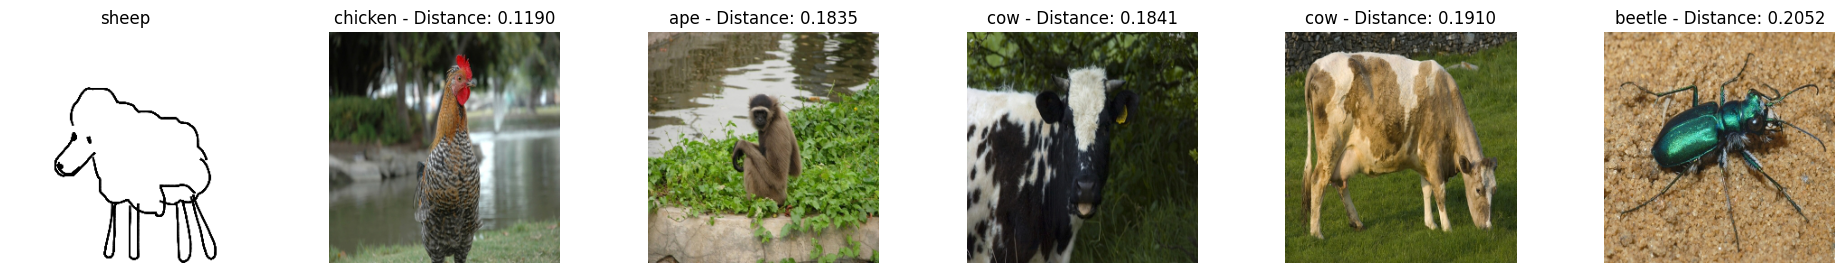

In [ ]:
#{ run: "auto", display-mode: "form" }
INDEX = 1357  #@param {type:"slider", min:0, max:1718, step:1}

a = sketches_k_acc[INDEX][0]

distances, topk_indexes = embedding_space.top_k(a[None, :].to(DEVICE), 5)

fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(24, 3))

axes[0].imshow(torch.permute(a, (1,2,0)))
axes[0].set_title(f'{images_ds.classes[sketches_k_acc[INDEX][1]]}')
axes[0].axis('off')

for i in range(0, topk_indexes.size(dim = 0)):
    axes[i+1].imshow(torch.permute(images_ds[topk_indexes[i]][0], (1, 2, 0)))
    axes[i+1].set_title(f'{images_ds.classes[images_ds[topk_indexes[i]][1]]} - Distance: {distances[i].item():.4f}')
    axes[i+1].axis('off')

plt.show()

# 🔸 Draw your sketch!

In [ ]:
canvas_html = """
<canvas width=%d height=%d></canvas>
<button>Finish</button>
<script>
var canvas = document.querySelector('canvas')
ctx = canvas.getContext('2d')
ctx.fillStyle = "#FFFFFF";
ctx.fillRect(0, 0, canvas.width, canvas.height);
var ctx = canvas.getContext('2d')
ctx.lineWidth = %d
var button = document.querySelector('button')
var mouse = {x: 0, y: 0}

canvas.addEventListener('mousemove', function(e) {
  mouse.x = e.pageX - this.offsetLeft
  mouse.y = e.pageY - this.offsetTop
})
canvas.onmousedown = ()=>{
  ctx.beginPath()
  ctx.moveTo(mouse.x, mouse.y)
  canvas.addEventListener('mousemove', onPaint)
}
canvas.onmouseup = ()=>{
  canvas.removeEventListener('mousemove', onPaint)
}
var onPaint = ()=>{
  ctx.lineTo(mouse.x, mouse.y)
  ctx.stroke()
}

var data = new Promise(resolve=>{
  button.onclick = ()=>{
    resolve(canvas.toDataURL('image/png'))
  }
})
</script>
"""

def draw(filename='drawing.png', w=400, h=200, line_width=1):
  display(HTML(canvas_html % (w, h, line_width)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return f'File Saved as {filename}'

In [ ]:
embedding_space = EmbeddingSpace(net, images_loader, DEVICE)

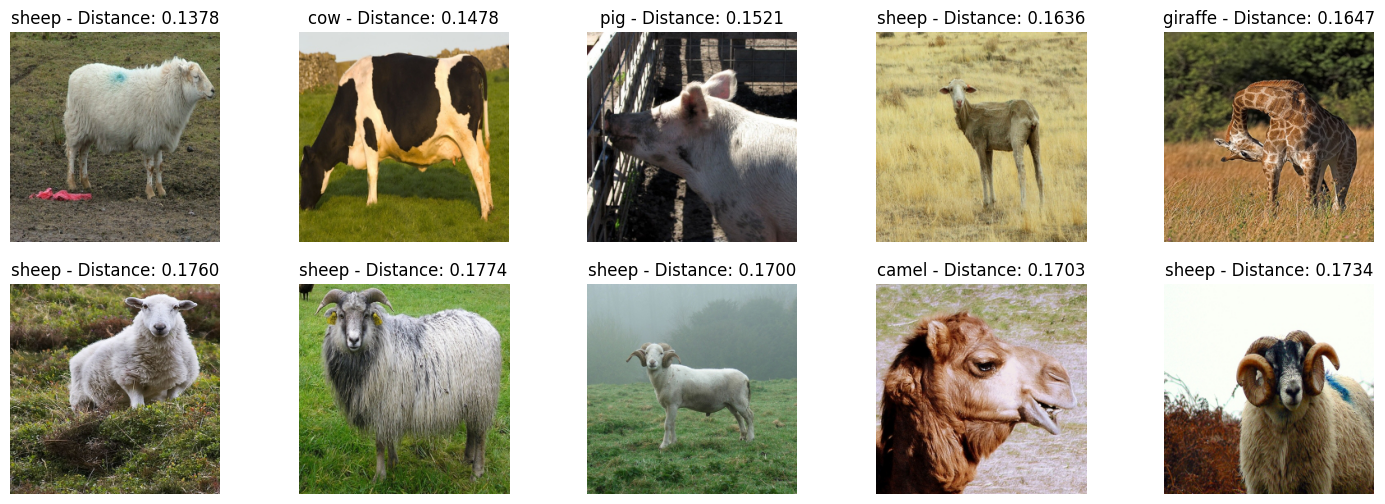

In [ ]:
FILENAME = "image.png"

draw(filename = FILENAME, w=256, h=256, line_width=2)
  
# Read a PIL image
image = IMG.open(FILENAME).convert('RGB')
  
# Define a transform to convert PIL 
# image to a Torch tensor
transform = transforms.Compose([
    transforms.ToTensor()
])
  
# transform = transforms.PILToTensor()
# Convert the PIL image to Torch tensor
img_tensor = transform(image).to(DEVICE)

distances, topk_indexes = embedding_space.top_k(img_tensor[None, :], 12)
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(18,6))

row, col = 0, 0
for i in range(0, topk_indexes.size(dim = 0)):
    axes[row][col].imshow(torch.permute(images_ds[topk_indexes[i]][0], (1, 2, 0)))
    axes[row][col].set_title(f'{sketches_ds.classes[images_ds[topk_indexes[i]][1]]} - Distance: {distances[i].item():.4f}')
    axes[row][col].axis('off')
    col += 1
    if col == 5:
      row = 1
      col = 0

plt.show()